In [2]:
# ============================================
# Import libraries untuk evaluasi model
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Metrics untuk evaluasi
from sklearn.metrics import (
    confusion_matrix,           # Matrix TP, TN, FP, FN
    classification_report,      # Report lengkap precision, recall, f1
    roc_curve,                  # Data untuk plot ROC curve
    roc_auc_score,              # AUC score
    precision_recall_curve,     # Precision-recall tradeoff
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# SHAP untuk model interpretability
import shap

import warnings
warnings.filterwarnings('ignore')



In [3]:
# ============================================
# Load trained model dan test data
# ============================================

# Load best model yang sudah di-save
model = joblib.load(r'D:\churn-app\models\churn_model.pkl')

# Load test data
X_test = pd.read_csv(r'D:\churn-app\data\processed\X_test.csv')
y_test = pd.read_csv(r'D:\churn-app\data\processed\y_test.csv').values.ravel()

print(f"Model loaded: {type(model).__name__}")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Churn rate in test: {y_test.mean():.2%}")

Model loaded: RandomForestClassifier
Test set: 1409 samples, 35 features
Churn rate in test: 26.54%


In [4]:
# ============================================
# Generate predictions pada test set
# ============================================

# Binary predictions (0 atau 1)
y_pred = model.predict(X_test)

# Probability predictions (0.0 - 1.0)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability untuk class 1 (churn)

print("Predictions generated")
print(f"Predicted churn rate: {y_pred.mean():.2%}")
print(f"Average churn probability: {y_proba.mean():.2%}")

Predictions generated
Predicted churn rate: 37.97%
Average churn probability: 38.27%


In [5]:
# ============================================
# Menghitung semua evaluation metrics
# ============================================

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print metrics
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f}    ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}     ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f}   ({roc_auc*100:.2f}%)")
print("="*60)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

MODEL PERFORMANCE METRICS
Accuracy:  0.7566  (75.66%)
Precision: 0.5290 (52.90%)
Recall:    0.7567    (75.67%)
F1-Score:  0.6227     (62.27%)
ROC-AUC:   0.8381   (83.81%)

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82      1035
       Churn       0.53      0.76      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



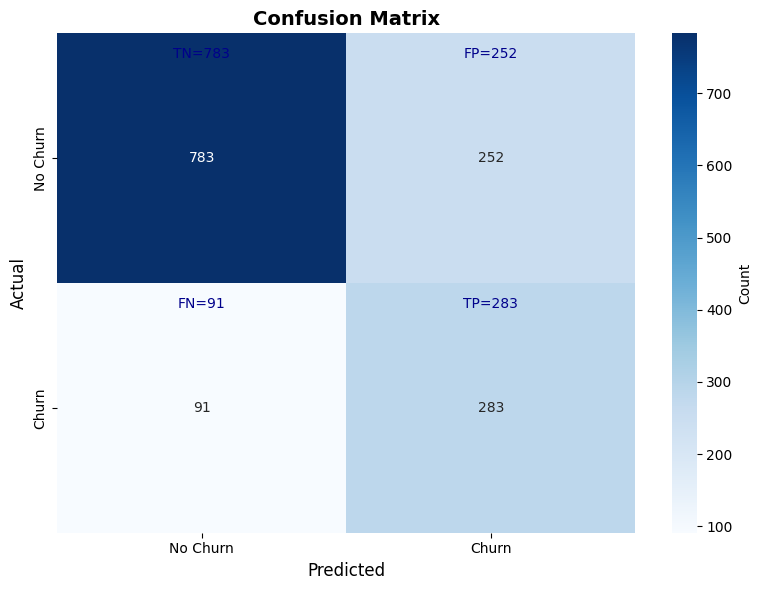


Confusion Matrix Breakdown:
True Negatives (TN):  783 - Correctly predicted No Churn
False Positives (FP): 252 - Incorrectly predicted Churn
False Negatives (FN): 91 - Missed Churn cases
True Positives (TP):  283 - Correctly predicted Churn


In [6]:
# ============================================
# Confusion Matrix - visualisasi TP, TN, FP, FN
# ============================================

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add text annotations
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, 0.1, f'TN={tn}', ha='center', fontsize=10, color='darkblue')
plt.text(1.5, 0.1, f'FP={fp}', ha='center', fontsize=10, color='darkblue')
plt.text(0.5, 1.1, f'FN={fn}', ha='center', fontsize=10, color='darkblue')
plt.text(1.5, 1.1, f'TP={tp}', ha='center', fontsize=10, color='darkblue')

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\confusion_matrix.png', dpi=150)
plt.show()

# Print interpretation
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn} - Correctly predicted No Churn")
print(f"False Positives (FP): {fp} - Incorrectly predicted Churn")
print(f"False Negatives (FN): {fn} - Missed Churn cases")
print(f"True Positives (TP):  {tp} - Correctly predicted Churn")

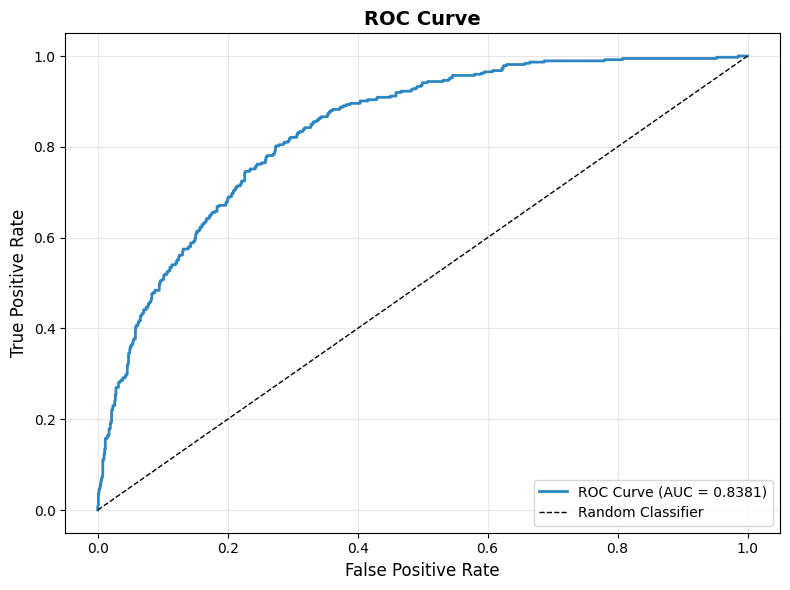


✅ ROC-AUC Score: 0.8381
Interpretation:
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random classifier
- AUC = 0.8381: Current model performance


In [7]:
# ============================================
# ROC Curve - visualisasi tradeoff TPR vs FPR
# ============================================

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#2E86C1', linewidth=2, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\roc_curve.png', dpi=150)
plt.show()

print(f"\n✅ ROC-AUC Score: {roc_auc:.4f}")
print("Interpretation:")
print("- AUC = 1.0: Perfect classifier")
print("- AUC = 0.5: Random classifier")
print(f"- AUC = {roc_auc:.4f}: Current model performance")

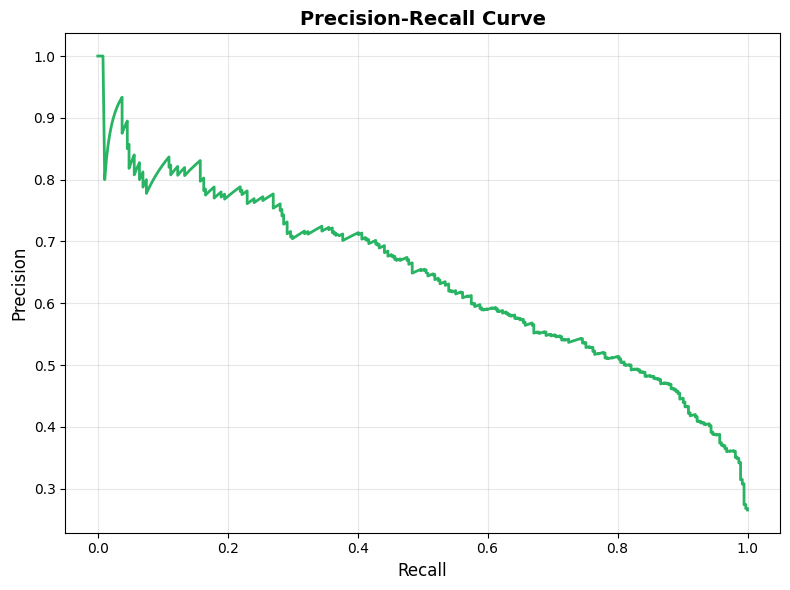

Precision-Recall curve generated


In [9]:
# ============================================
# Precision-Recall Curve
# ============================================

# Calculate precision-recall curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='#28B463', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\precision_recall_curve.png', dpi=150)
plt.show()

print("Precision-Recall curve generated")

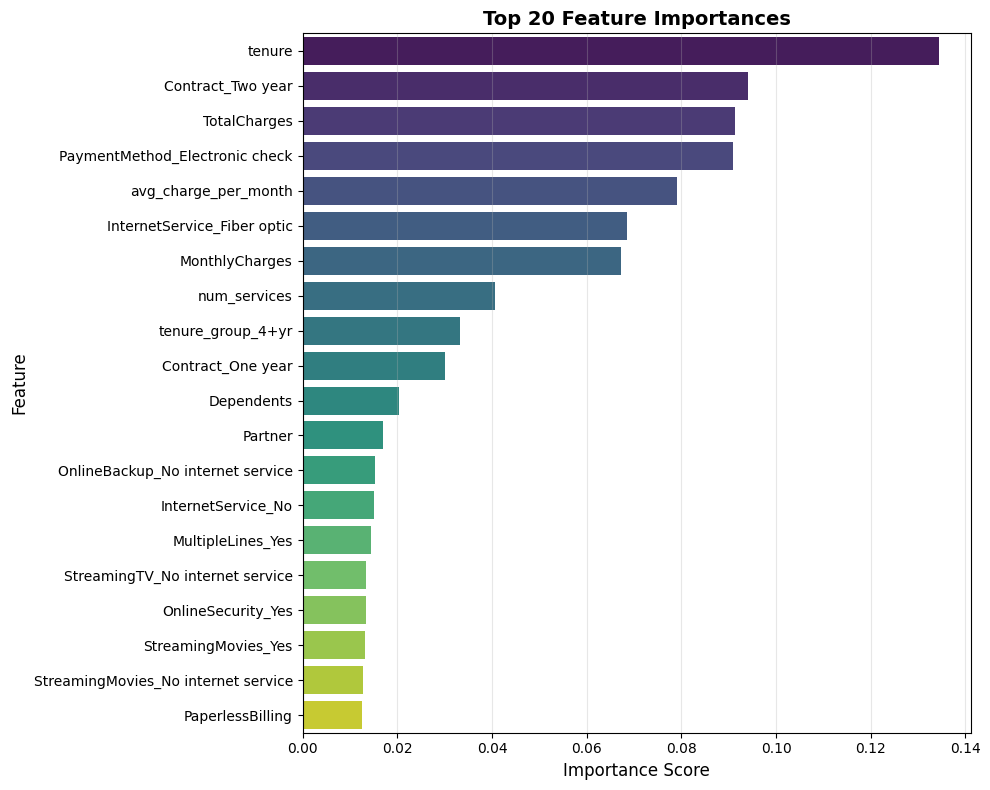


Top 10 Most Important Features:
                       feature  importance
                        tenure    0.134416
             Contract_Two year    0.093992
                  TotalCharges    0.091378
PaymentMethod_Electronic check    0.090885
          avg_charge_per_month    0.078998
   InternetService_Fiber optic    0.068557
                MonthlyCharges    0.067350
                  num_services    0.040595
             tenure_group_4+yr    0.033308
             Contract_One year    0.030059


In [10]:
# ============================================
# Feature Importance dari model
# ============================================

# Get feature importance (untuk tree-based models)
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), 
            y='feature', x='importance', 
            palette='viridis')

plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\feature_importance.png', dpi=150)
plt.show()

# Print top 10
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

Computing SHAP values... (this may take 1-2 minutes)
✅ SHAP values computed


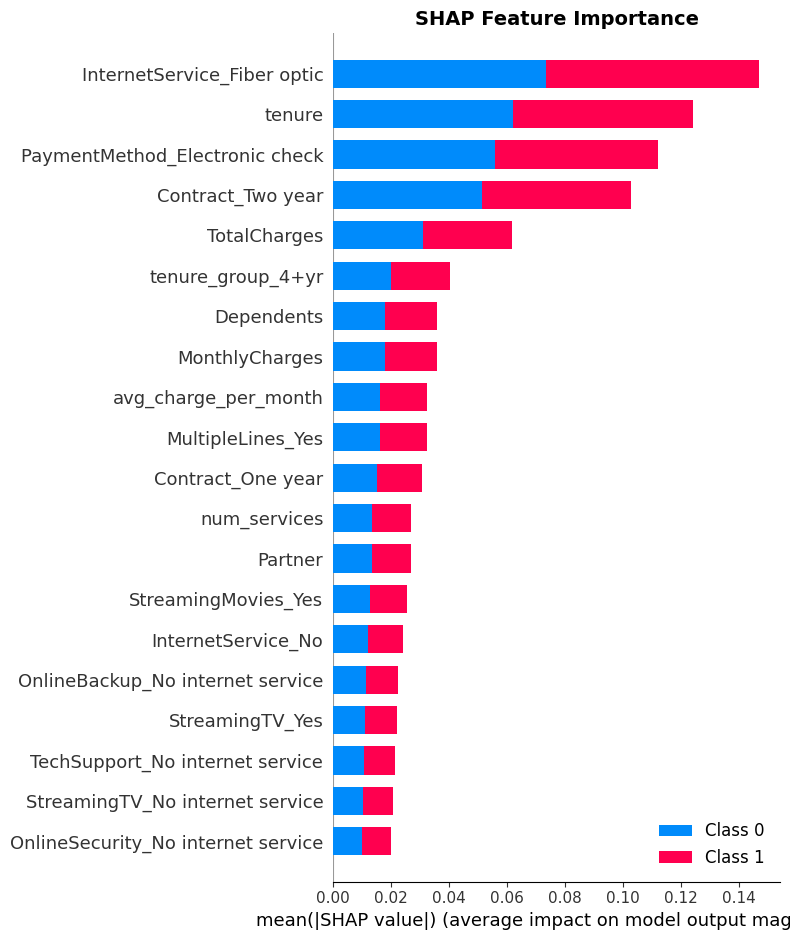

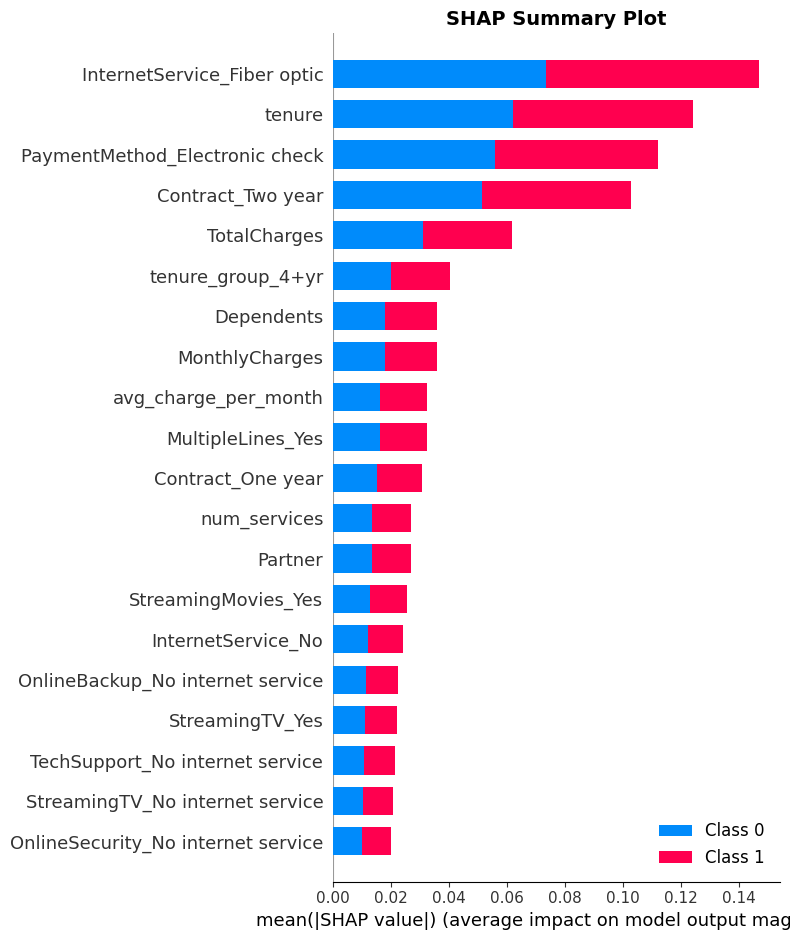

✅ SHAP analysis complete


In [11]:
# ============================================
# SHAP Analysis untuk model interpretability
# ============================================

print("Computing SHAP values... (this may take 1-2 minutes)")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values (sample 500 untuk speed)
sample_size = min(500, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_sample)

print("✅ SHAP values computed")

# Summary plot (bar)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\shap_importance.png', dpi=150)
plt.show()

# Summary plot (beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\shap_summary.png', dpi=150)
plt.show()

print("✅ SHAP analysis complete")

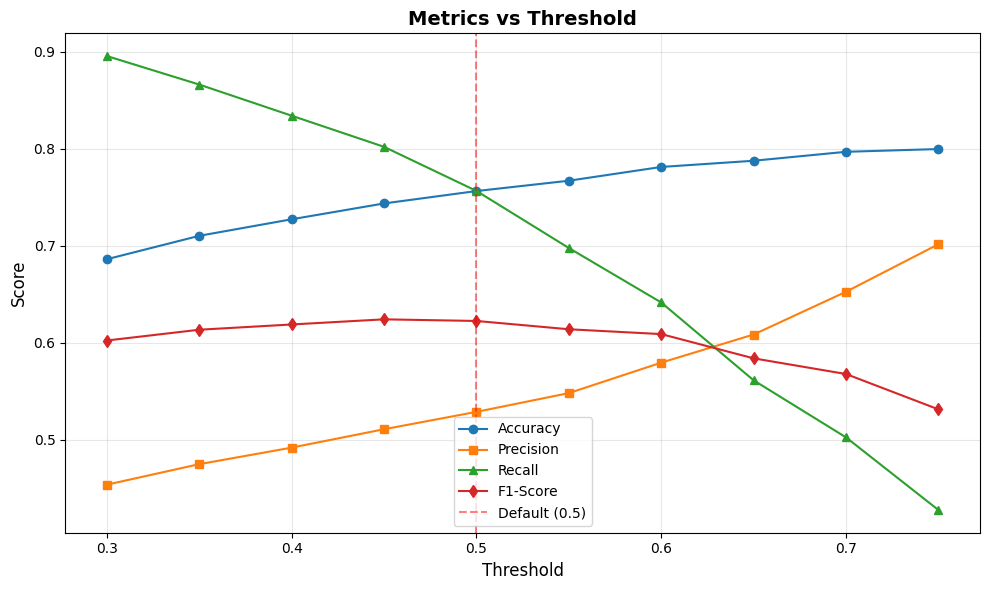


Optimal Threshold: 0.45
F1-Score at optimal threshold: 0.6243


In [12]:
# ============================================
# Analisis optimal threshold untuk classification
# ============================================

# Test different thresholds
thresholds = np.arange(0.3, 0.8, 0.05)
results_threshold = []

for threshold in thresholds:
    y_pred_threshold = (y_proba >= threshold).astype(int)
    
    results_threshold.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, y_pred_threshold),
        'precision': precision_score(y_test, y_pred_threshold),
        'recall': recall_score(y_test, y_pred_threshold),
        'f1': f1_score(y_test, y_pred_threshold)
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(results_threshold)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o', label='Accuracy')
ax.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='Precision')
ax.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='Recall')
ax.plot(threshold_df['threshold'], threshold_df['f1'], marker='d', label='F1-Score')

ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\threshold_analysis.png', dpi=150)
plt.show()

# Find optimal threshold (maximize F1)
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"F1-Score at optimal threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")

In [13]:
# ============================================
# Menghitung business impact dari model
# ============================================

# Business assumptions
RETENTION_COST = 100        # Cost untuk retention effort per customer ($)
ANNUAL_REVENUE = 1000       # Revenue per customer per year ($)
RETENTION_SUCCESS_RATE = 0.3  # 30% success rate retention effort

# Calculate business metrics
high_risk_threshold = 0.7  # Customer dengan probability > 70% = high risk
high_risk_customers = (y_proba >= high_risk_threshold).sum()

# True positives at high risk threshold
tp_high_risk = ((y_proba >= high_risk_threshold) & (y_test == 1)).sum()
fp_high_risk = ((y_proba >= high_risk_threshold) & (y_test == 0)).sum()

# Expected customers retained
customers_retained = tp_high_risk * RETENTION_SUCCESS_RATE

# Revenue saved
revenue_saved = customers_retained * ANNUAL_REVENUE

# Total cost
total_cost = (tp_high_risk + fp_high_risk) * RETENTION_COST

# Net benefit
net_benefit = revenue_saved - total_cost

# ROI
roi = (net_benefit / total_cost * 100) if total_cost > 0 else 0

# Print results
print("="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)
print(f"Customers targeted (>70% risk):  {high_risk_customers}")
print(f"True churners caught:             {tp_high_risk}")
print(f"False alarms:                     {fp_high_risk}")
print(f"Expected customers retained:      {customers_retained:.0f}")
print(f"\nFinancial Impact:")
print(f"Revenue saved:                    ${revenue_saved:,.2f}")
print(f"Total retention cost:             ${total_cost:,.2f}")
print(f"Net benefit:                      ${net_benefit:,.2f}")
print(f"ROI:                              {roi:.2f}%")
print("="*60)

BUSINESS IMPACT ANALYSIS
Customers targeted (>70% risk):  288
True churners caught:             188
False alarms:                     100
Expected customers retained:      56

Financial Impact:
Revenue saved:                    $56,400.00
Total retention cost:             $28,800.00
Net benefit:                      $27,600.00
ROI:                              95.83%


In [15]:
# ============================================
# Generate summary report
# ============================================

summary = f"""
{"="*60}
MODEL EVALUATION SUMMARY
{"="*60}

MODEL INFORMATION:
- Model Type: {type(model).__name__}
- Test Set Size: {len(X_test)} samples
- Features: {X_test.shape[1]}

PERFORMANCE METRICS:
- Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)
- Precision: {precision:.4f} ({precision*100:.2f}%)
- Recall:    {recall:.4f} ({recall*100:.2f}%)
- F1-Score:  {f1:.4f} ({f1*100:.2f}%)
- ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)

CONFUSION MATRIX:
- True Negatives:  {tn}
- False Positives: {fp}
- False Negatives: {fn}
- True Positives:  {tp}

BUSINESS IMPACT (at 70% threshold):
- Customers targeted: {high_risk_customers}
- Expected retained:  {customers_retained:.0f}
- Net benefit:        ${net_benefit:,.2f}
- ROI:                {roi:.2f}%

KEY INSIGHTS:
1. Model dapat predict churn dengan ROC-AUC {roc_auc:.4f}
2. Dari {tp+fn} actual churners, model menangkap {tp} ({recall*100:.1f}%)
3. Dari {tp+fp} predicted churners, {tp} benar ({precision*100:.1f}%)
4. Expected ROI dari retention effort: {roi:.1f}%

RECOMMENDATIONS:
- Focus retention pada customers dengan churn probability > 70%
- Monitor false negatives untuk improve recall
- Consider adjusting threshold berdasarkan business goals

{"="*60}
"""

print(summary)

# Save report
with open(r'D:\churn-app\outputs\reports\evaluation_summary.txt', 'w') as f:
    f.write(summary)

print("\nEvaluation complete! Report saved.")


MODEL EVALUATION SUMMARY

MODEL INFORMATION:
- Model Type: RandomForestClassifier
- Test Set Size: 1409 samples
- Features: 35

PERFORMANCE METRICS:
- Accuracy:  0.7566 (75.66%)
- Precision: 0.5290 (52.90%)
- Recall:    0.7567 (75.67%)
- F1-Score:  0.6227 (62.27%)
- ROC-AUC:   0.8381 (83.81%)

CONFUSION MATRIX:
- True Negatives:  783
- False Positives: 252
- False Negatives: 91
- True Positives:  283

BUSINESS IMPACT (at 70% threshold):
- Customers targeted: 288
- Expected retained:  56
- Net benefit:        $27,600.00
- ROI:                95.83%

KEY INSIGHTS:
1. Model dapat predict churn dengan ROC-AUC 0.8381
2. Dari 374 actual churners, model menangkap 283 (75.7%)
3. Dari 535 predicted churners, 283 benar (52.9%)
4. Expected ROI dari retention effort: 95.8%

RECOMMENDATIONS:
- Focus retention pada customers dengan churn probability > 70%
- Monitor false negatives untuk improve recall
- Consider adjusting threshold berdasarkan business goals



Evaluation complete! Report saved.
